In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib

In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import palettable

In [6]:
import sys
import pathlib

### import the local package 

In [7]:
sys.path.append('../../')

In [8]:
import seaborn as sns

In [9]:
from ICU_Water_Watch import C3S, geo, plot, utils, verification

In [10]:
from datetime import datetime, timedelta
from calendar import month_abbr

In [11]:
import numpy as np
import pandas as pd 
import xarray as xr

In [12]:
import cartopy.crs as ccrs 

In [13]:
from shapely.geometry import Point, Polygon
import regionmask

### climpred HindcastEnsemble Class

In [14]:
from climpred import HindcastEnsemble

### logging, to see what `climpred` is doing under the hood 

In [15]:
import logging
logger = logging.getLogger()

logger.setLevel(logging.INFO) # minimum and maximum bounds for initializations and verification dates

# logger.setLevel(logging.DEBUG) # every single initialisation and verif date used 

### progress bar for dask compute 

In [16]:
from dask.diagnostics import ProgressBar

In [17]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

### path definitions 

In [18]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [19]:
fig_path = CWD.parents[3] / 'figures'

### domain for the calculation of the ACC 

In [20]:
domains = {}
domains['Tropical_Pacific'] = [140, 360-140, -25, 25]
domains['SW_Pacific'] = [172.5, 190, -22.5, -12]
domains['Fiji'] = [175, 183, -21, -15]
domains['NZ'] = [161, 181, -50, -30] 
domains['Pacific'] = [140, 360-120, -50, 25]

In [21]:
domain_name = 'Tropical_Pacific'

In [22]:
domain = domains[domain_name]

In [23]:
area = geo.gpd_from_domain(*domain)

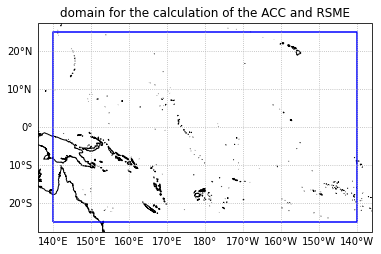

In [24]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
# dset_obs['precip'][0,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
area.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='b')
ax.coastlines(resolution='10m'); 
ax.set_title('domain for the calculation of the ACC and RSME')
gl = ax.gridlines(draw_labels=True, linestyle=':', xlocs=np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
gl.top_labels = False
gl.right_labels = False
f.savefig(fig_path.joinpath(f'verification/ACC_RMSE_domain_{domain_name}.png'), dpi=200, bbox_inches='tight', facecolor='w')

### verification dataset 

In [25]:
use_verif = 'era'

In [26]:
GCMs = ['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP']

In [27]:
varname = 'tprate'

In [28]:
period = 'monthly'

In [29]:
year_start = 1993 
year_end = 2016

In [30]:
if use_verif == 'gpcp': 
    obs, dset_obs = verification.get_gpcp()
    del(obs)
    dset_obs = utils.interp_to_1x(dset_obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
if use_verif == 'cmap': 
    obs, dset_obs = verification.get_cmap()
    del(obs)
    dset_obs = utils.interp_to_1x(dset_obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
elif use_verif == 'mswep': 
    obs, dset_obs = verification.get_mswep()
    del(obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))
    
elif use_verif == 'era': 
    obs, dset_obs = verification.get_era5()
    del(obs)
    dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))    

### get rid of the junk 

In [31]:
for jvar in ['lat_bnds', 'lon_bnds']:
    if jvar in dset_obs.data_vars: 
        dset_obs = dset_obs.drop(jvar)

In [32]:
period

'monthly'

In [33]:
if period == 'seasonal': 
    dset_obs = dset_obs.rolling({'time':3}, min_periods=3).mean('time')
    dset_obs = dset_obs.isel(time=slice(2, None))

In [34]:
dset_obs

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 81, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 51, 81), meta=np.ndarray>

### Now reads the GCMs

### we are only looking for now at the "C3S" GCMs, as the other ones (KMA, NASA, MSC) do not necessarily cover the whole period 

### extract only the domain needed

In [35]:
MME = C3S.get_GCMs(GCM=GCMs, domain=domain, varname=varname)

---------------------------------------------------
reading ECMWF

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/ECMWF/TPRATE/ensemble_seas_forecasts_tprate_from_2016_12_ECMWF.netcdf

unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip
---------------------------------------------------
reading UKMO

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE/ensemble_seas_forecasts_tprate_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/UKMO/TPRATE/ensemble_seas_forecasts_tprate_from_2016_12_UKMO.netcdf

unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in v

In [36]:
if period == 'seasonal': 
    MME = MME.rolling({'step':3}, min_periods=3).mean('step')
    MME = MME.sel(step=slice(3, None))

### re-chunk, each chunk will take ~ 7 Mb in memory

In [37]:
MME = MME.chunk({'GCM':-1, 'time':-1, 'step':-1, 'lon':-1, 'lat':-1})

In [38]:
MME

<xarray.Dataset>
Dimensions:  (GCM: 6, lat: 51, lon: 81, step: 5, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP'
  * lon      (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
  * lat      (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * step     (step) int64 1 2 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(6, 288), meta=np.ndarray>
Data variables:
    precip   (GCM, time, step, lat, lon) float64 dask.array<chunksize=(6, 288, 5, 51, 81), meta=np.ndarray>

### add the ensemble mean to the set of GCMs

In [39]:
MME_mean = MME.mean('GCM')

In [40]:
MME_mean

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 81, step: 5, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lon      (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
  * lat      (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, lat, lon) float64 dask.array<chunksize=(288, 5, 51, 81), meta=np.ndarray>

In [41]:
MME_mean = MME_mean.expand_dims({'GCM':['MME']})

In [42]:
MME

<xarray.Dataset>
Dimensions:  (GCM: 6, lat: 51, lon: 81, step: 5, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP'
  * lon      (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
  * lat      (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * step     (step) int64 1 2 3 4 5
    month    (GCM, time) float64 dask.array<chunksize=(6, 288), meta=np.ndarray>
Data variables:
    precip   (GCM, time, step, lat, lon) float64 dask.array<chunksize=(6, 288, 5, 51, 81), meta=np.ndarray>

In [43]:
dset_obs

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 81, time: 288)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float64 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * lon      (lon) float64 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(1, 51, 81), meta=np.ndarray>

In [44]:
if 'month' in MME.coords: 
    MME = MME.drop('month')

In [45]:
MME = xr.concat([MME, MME_mean], dim='GCM')

In [46]:
MME = MME.dropna(dim='time')

In [47]:
MME

<xarray.Dataset>
Dimensions:  (GCM: 7, lat: 51, lon: 81, step: 5, time: 287)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'MME'
  * lon      (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
  * lat      (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (GCM, time, step, lat, lon) float64 dask.array<chunksize=(6, 287, 5, 51, 81), meta=np.ndarray>

### process to make all the variables and dimension names compatible with climpred

In [48]:
MME = verification.process_for_climpred(MME)

In [49]:
MME

<xarray.Dataset>
Dimensions:  (GCM: 7, init: 287, lat: 51, lead: 5, lon: 81)
Coordinates:
  * init     (init) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'MME'
  * lon      (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
  * lat      (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
  * lead     (lead) int64 1 2 3 4 5
Data variables:
    precip   (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(6, 287, 5, 51, 81), meta=np.ndarray>

### re-chunk the MME 

In [50]:
MME = MME.chunk({'init':-1, 'lead':1, 'lat':-1, 'lon':-1})

### re-chunk the observations 

In [51]:
dset_obs = dset_obs.chunk({'time':-1, 'lat':-1, 'lon':-1})

In [52]:
dset_obs.chunks

Frozen(SortedKeysDict({'time': (288,), 'lat': (51,), 'lon': (81,)}))

### create the hindcast ensemble over all the GCMs (including the MME)

In [53]:
hindcast = HindcastEnsemble(MME)

In [54]:
hindcast

climpred.HindcastEnsemble

<Initialized Ensemble>
Dimensions: (GCM: 7, init: 287, lat: 51, lead: 5, lon: 81)
Coordinates:
 * init (init) object 1993-02-01 00:00:00 ... 2016-12-01 00:00:00
 * GCM (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'MME'
 * lon (lon) float32 140.0 141.0 142.0 143.0 ... 217.0 218.0 219.0 220.0
 * lat (lat) float32 -25.0 -24.0 -23.0 -22.0 -21.0 ... 22.0 23.0 24.0 25.0
 * lead (lead) int64 1 2 3 4 5
Data variables:
 precip (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(6, 287, 1, 51, 81), meta=np.ndarray> Initialized Ensemble Dimensions: GCM : 7 init : 287 lat : 51 lead : 5 lon : 81 Coordinates: (5) init (init) object 1993-02-01 00:00:00 ... 2016-12-... array([cftime.DatetimeProlepticGregorian(1993, 2, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1993, 3, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(1993, 4, 1, 0, 0, 0, 0), ...,
 cftime.DatetimeProlepticGregorian(2016, 10, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2016, 11, 1, 0, 0, 0, 0),
 cftime.DatetimeProlepticGregorian(2016, 12, 1, 0, 0, 0, 0)],
 dtype=object) GCM (GCM) <U12 'ECMWF' 'UKMO' ... 'NCEP' 'MME' array(['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'MME'],
 dtype='<U12') lon (lon) float32 140.0 141.0 142.0 ... 219.0 220.0 units : degrees_east long_name : longitude array([140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150., 151.,
 152., 153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
 164., 165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
 176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
 188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198., 199.,
 200., 201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211.,
 212., 213., 214., 215., 216., 217., 218., 219., 220.], dtype=float32) lat (lat) float32 -25.0 -24.0 -23.0 ... 24.0 25.0 units : degrees_north long_name : latitude array([-25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15., -14.,
 -13., -12., -11., -10., -9., -8., -7., -6., -5., -4., -3., -2.,
 -1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.,
 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
 23., 24., 25.], dtype=float32) lead (lead) int64 1 2 3 4 5 units : months array([1, 2, 3, 4, 5]) Data variables: (1) precip (GCM, init, lead, lat, lon) float64 dask.array<chunksize=(6, 287, 1, 51, 81), meta=np.ndarray> 
 
 
 
 
 Array Chunk 
 
 
 Bytes 316.59 MiB 54.27 MiB 
 Shape (7, 287, 5, 51, 81) (6, 287, 1, 51, 81) 
 Count 39195 Tasks 10 Chunks 
 Type float64 numpy.ndarray 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 287 
 7 


 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 
 
 
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 
 
 
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 81 
 51 
 5 
 
 
 
 Attributes: (0)

### repeat the observations over the `GCM` dimension 

In [55]:
dset_obs_repeat = xr.concat([dset_obs for i in range(len(MME['GCM']))], dim='GCM') 
dset_obs_repeat['GCM'] = MME['GCM']

In [56]:
hindcast = hindcast.add_observations(dset_obs_repeat)

### calculate the ACC variability (i.e. for **each** initial month and year)

In [57]:
ACC_variability = hindcast.verify(metric='acc', comparison='e2o', dim=['lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


### do the same for the RMSE

In [58]:
RMSE_variability = hindcast.verify(metric='rmse', comparison='e2o', dim=['lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [59]:
with ProgressBar(): 
    ACC_variability = ACC_variability.compute()
    RMSE_variability = RMSE_variability.compute()

[################################        ] | 80% Completed | 21.2s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.3s
[################################        ] | 81% Completed | 21.2s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.3s


### ACC variability plot for each lead time 

In [60]:
CWD

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification')

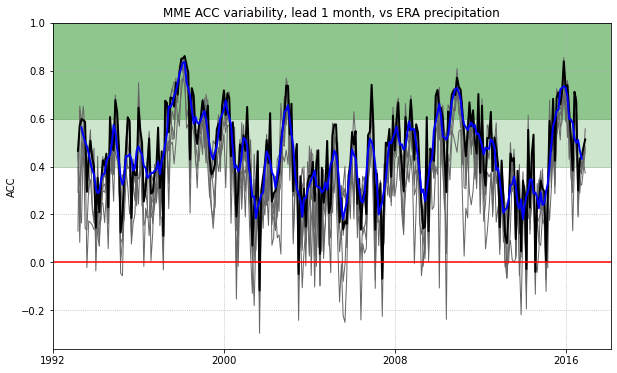

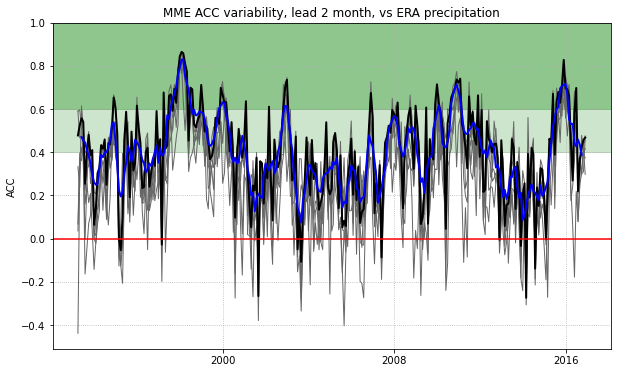

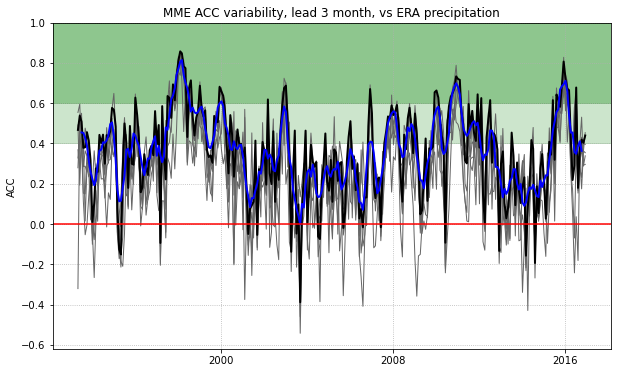

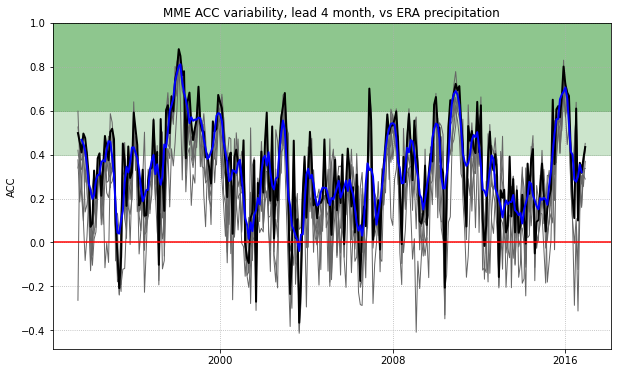

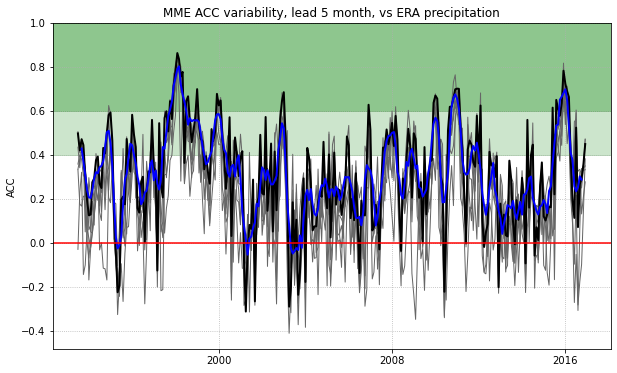

In [61]:
for lead in ACC_variability.lead.data: 
    f, ax = plt.subplots(figsize=(10,6))
    for GCM in GCMs: 
        ACC_variability.sel(GCM=GCM, lead=lead)['precip'].plot(ax=ax, lw=1, color='0.4')
    ACC_variability.sel(GCM="MME", lead=lead)['precip'].plot(ax=ax, color='k', lw=2)
    ACC_variability.sel(GCM="MME", lead=lead)['precip'].rolling({'init':5}, center=True).mean().plot(ax=ax, color='b', lw=2)
    ax.grid(ls=':')
    ax.axhspan(0.4, 1, color='g', alpha=0.2)
    ax.axhspan(0.6, 1, color='g', alpha=0.3)
    ax.set_ylim(None, 1)
    ax.axhline(0, color='r')
    ax.set_title(f'MME ACC variability, lead {lead} month, vs {use_verif.upper()} precipitation')
    ax.set_ylabel('ACC')
    ax.set_xlabel('')
    f.savefig(fig_path.joinpath(f'verification/ACC_variability_MME_{varname}_vs_{use_verif.upper()}_lead_{lead}.png'), dpi=200, bbox_inches='tight', facecolor='w')

### Now calculates the ACC for all init times, along lat and lon 

In [62]:
ACC = hindcast.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [63]:
RMSE = hindcast.verify(metric='rmse', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [64]:
with ProgressBar(): 
    ACC = ACC.compute()

[###############################         ] | 79% Completed | 21.3s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.5s


In [65]:
with ProgressBar(): 
    RMSE = RMSE.compute()

[###############################         ] | 78% Completed | 21.1s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.1s


In [66]:
ACC

<xarray.Dataset>
Dimensions:  (GCM: 7, lead: 5)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'MME'
    skill    <U11 'initialized'
Data variables:
    precip   (lead, GCM) float64 0.5208 0.4812 0.4473 ... 0.3437 0.274 0.4167

In [67]:
RMSE

<xarray.Dataset>
Dimensions:  (GCM: 7, lead: 5)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5
  * GCM      (GCM) <U12 'ECMWF' 'UKMO' 'METEO_FRANCE' 'DWD' 'CMCC' 'NCEP' 'MME'
    skill    <U11 'initialized'
Data variables:
    precip   (lead, GCM) float64 53.14 53.93 55.86 63.07 ... 37.11 56.09 36.45

In [68]:
ACC_df = ACC['precip'].to_dataframe()['precip'].unstack()

In [69]:
RMSE_df = RMSE['precip'].to_dataframe()['precip'].unstack()

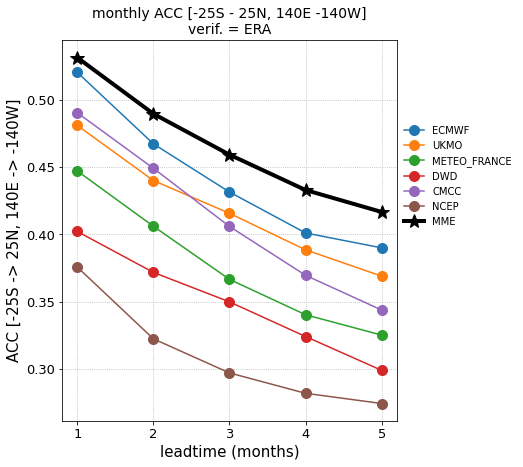

In [70]:
f, ax = plt.subplots(figsize=(6,7))
ACC_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
# ACC_df.loc[:,'Best_5'].plot(marker='s', markersize=10, ax=ax, color='0.4', label='Best 5', lw=4)
ACC_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(ACC.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} ACC [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 

# f.savefig(f'../../figures/validation/ACC_{"to".join(map(str, domain))}_verif_{use_verif.upper()}.png', dpi=200, bbox_inches='tight', facecolor='w')
f.savefig(fig_path.joinpath(f'verification/ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

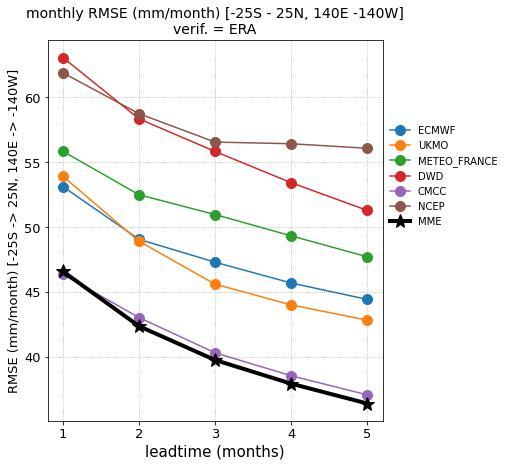

In [71]:
f, ax = plt.subplots(figsize=(6,7))
RMSE_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax)
# RMSE_df.loc[:,'Best_5'].plot(marker='s', markersize=10, ax=ax, color='0.4', label='Best 4', lw=4)
RMSE_df.loc[:,'MME'].plot(marker='*', markersize=15, ax=ax, color='k', label='MME', lw=4)
ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"RMSE (mm/month) [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=13);
ax.set_xticks(RMSE.lead.data)
ax.grid(ls=':')
ax.set_title(f"{period} RMSE (mm/month) [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 

f.savefig(fig_path.joinpath(f'verification/RMSE_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_maximize_alignment.png'), dpi=200, bbox_inches='tight', facecolor='w'); 

### per month 

In [72]:
ACC_per_month = []

for label, group in MME.groupby('init.month'):
    
    print(f"calculating metric for month {label}\n")

    hindcast_month = HindcastEnsemble(group)

    hindcast_month = hindcast_month.add_observations(dset_obs_repeat)

    skill_monthly = hindcast_month.verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')
    
    with ProgressBar(): 
        
        skill_monthly = skill_monthly.compute()

    ACC_per_month.append(skill_monthly.expand_dims({'month':[label]}))

INFO:root:lead: 01 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:lead: 02 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:lead: 03 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00


calculating metric for month 1



INFO:root:lead: 04 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:lead: 05 | inits: 1994-01-01 00:00:00-2016-01-01 00:00:00 | verifs: 1994-06-01 00:00:00-2016-06-01 00:00:00


[###############################         ] | 79% Completed | 21.7s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.7s


INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-03-01 00:00:00


calculating metric for month 2



INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-04-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-02-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00


[###############################         ] | 78% Completed | 21.5s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.4s


INFO:root:lead: 01 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-04-01 00:00:00


calculating metric for month 3



INFO:root:lead: 02 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:lead: 03 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:lead: 04 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:lead: 05 | inits: 1993-03-01 00:00:00-2016-03-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00


[###############################         ] | 79% Completed | 21.3s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.2s
calculating metric for month 4



INFO:root:lead: 01 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:lead: 02 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:lead: 03 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:lead: 04 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:lead: 05 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00


[################################        ] | 80% Completed | 21.3s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.1s


INFO:root:lead: 01 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00


calculating metric for month 5



INFO:root:lead: 02 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:lead: 03 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:lead: 04 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:lead: 05 | inits: 1993-05-01 00:00:00-2016-05-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00


[###############################         ] | 79% Completed | 21.1s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.1s
calculating metric for month 6



INFO:root:lead: 01 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:lead: 02 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:lead: 03 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:lead: 04 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:lead: 05 | inits: 1993-06-01 00:00:00-2016-06-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00


[###############################         ] | 79% Completed | 21.5s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.4s


INFO:root:lead: 01 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00


calculating metric for month 7



INFO:root:lead: 02 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00
INFO:root:lead: 03 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:lead: 04 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:lead: 05 | inits: 1993-07-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00


[################################        ] | 80% Completed | 22.3s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 23.1s


INFO:root:lead: 01 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00


calculating metric for month 8



INFO:root:lead: 02 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00
INFO:root:lead: 03 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:lead: 04 | inits: 1993-08-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-08-01 00:00:00-2015-08-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00


[###############################         ] | 79% Completed | 21.7s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.5s


INFO:root:lead: 01 | inits: 1993-09-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-10-01 00:00:00-2016-10-01 00:00:00


calculating metric for month 9



INFO:root:lead: 02 | inits: 1993-09-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:lead: 03 | inits: 1993-09-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 05 | inits: 1993-09-01 00:00:00-2015-09-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00


[###############################         ] | 79% Completed | 21.7s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 23.0s
calculating metric for month 10



INFO:root:lead: 01 | inits: 1993-10-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-11-01 00:00:00-2016-11-01 00:00:00
INFO:root:lead: 02 | inits: 1993-10-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 04 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:lead: 05 | inits: 1993-10-01 00:00:00-2015-10-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00


[################################        ] | 80% Completed | 21.8s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.8s
calculating metric for month 11



INFO:root:lead: 01 | inits: 1993-11-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-12-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00
INFO:root:lead: 03 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:lead: 04 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:lead: 05 | inits: 1993-11-01 00:00:00-2015-11-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00


[################################        ] | 80% Completed | 21.6s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.4s


INFO:root:lead: 01 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-01-01 00:00:00-2016-01-01 00:00:00


calculating metric for month 12



INFO:root:lead: 02 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-02-01 00:00:00-2016-02-01 00:00:00
INFO:root:lead: 03 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-03-01 00:00:00-2016-03-01 00:00:00
INFO:root:lead: 04 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-04-01 00:00:00-2016-04-01 00:00:00
INFO:root:lead: 05 | inits: 1993-12-01 00:00:00-2015-12-01 00:00:00 | verifs: 1994-05-01 00:00:00-2016-05-01 00:00:00


[################################        ] | 81% Completed | 22.0s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 22.8s


In [73]:
ACC_per_month = xr.concat(ACC_per_month, dim='month') 

In [74]:
ACC_per_month.lead.data[::-1]

array([5, 4, 3, 2, 1])

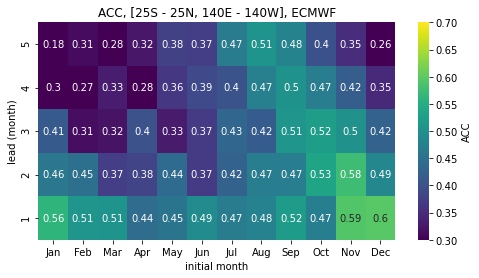

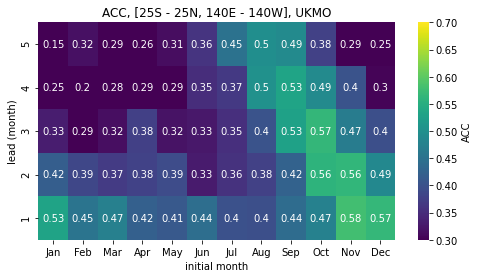

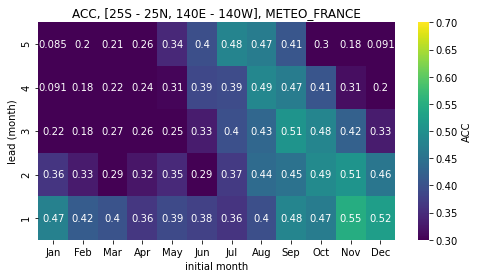

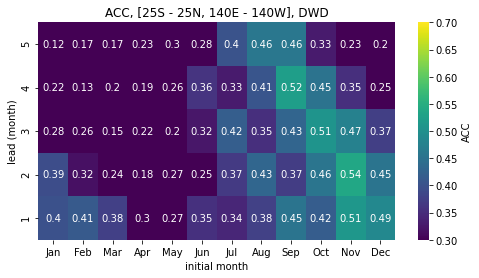

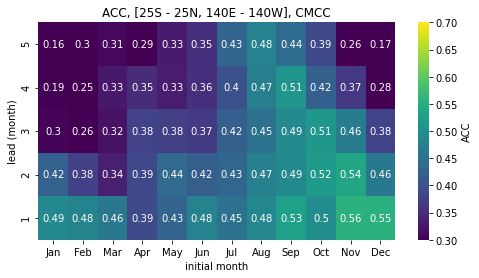

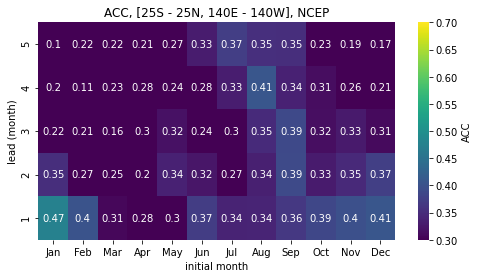

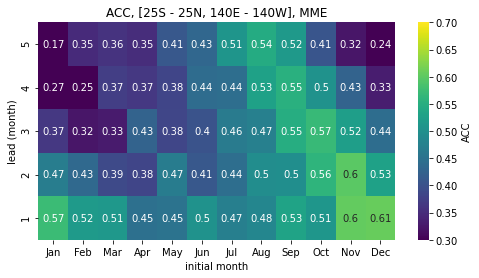

In [75]:
for GCM in GCMs + ['MME']:
    f, ax = plt.subplots(figsize=(8,4)); 
    _ = sns.heatmap(ACC_per_month.sel(GCM=GCM)['precip'].sortby('lead', ascending=False).transpose(), ax=ax, annot=True, cmap='viridis', vmin=0.3, vmax=0.7);
    ax.set_title(f'ACC, [25S - 25N, 140E - 140W], {GCM}')
    ax.set_yticklabels(ACC_per_month.lead.data[::-1]); 
    ax.set_ylabel('lead (month)');
    ax.set_xticklabels(month_abbr[1:]);
    ax.set_xlabel('initial month'); 
    f.axes[-1].set_ylabel('ACC');
    f.savefig(fig_path.joinpath(f'verification/{period}_dependent_ACC_{GCM}_{domain_name}_domain_verif_{use_verif.upper()}.png'), dpi=200, bbox_inches='tight', facecolor='w')

### correlation maps 

In [76]:
R_map = hindcast.verify(metric='pearson_r', comparison='e2o', dim=['init'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [77]:
with ProgressBar(): 
    R_map = R_map.compute()

[###############################         ] | 78% Completed | 21.9s

/home/nicolasf/mambaforge/envs/ICU/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 23.1s


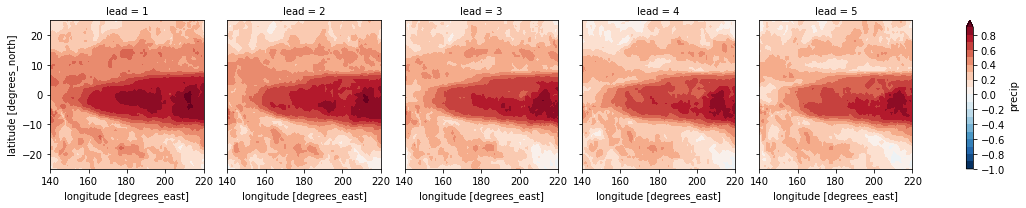

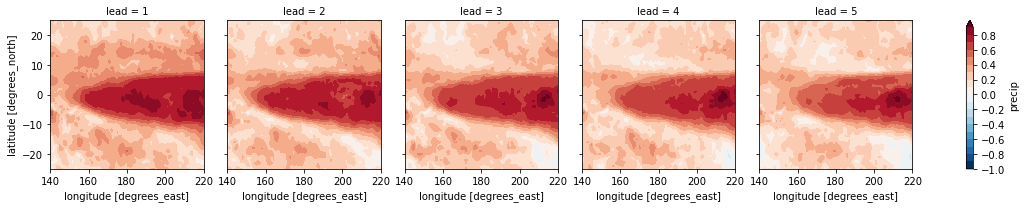

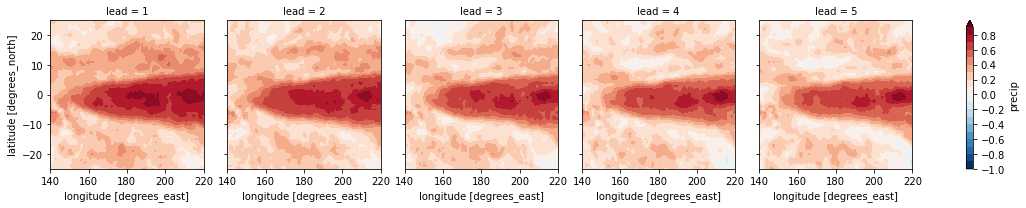

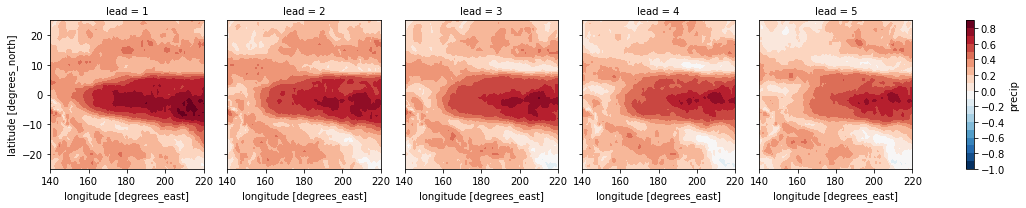

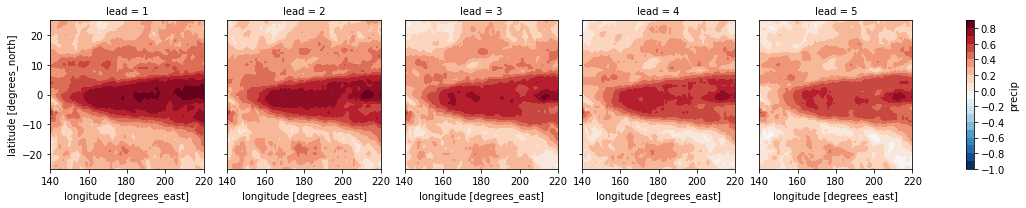

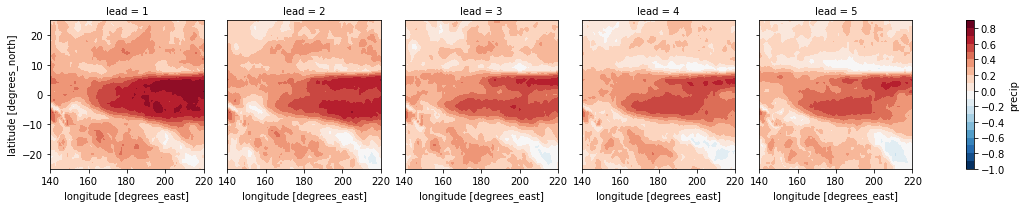

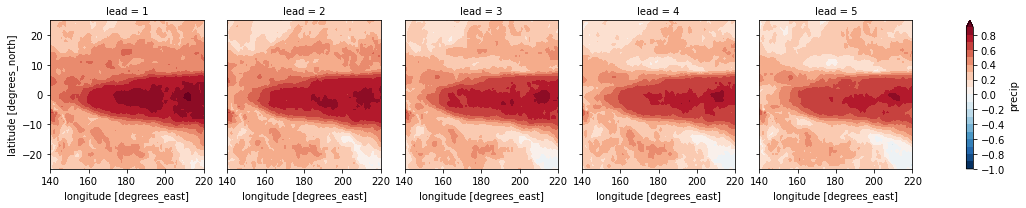

In [78]:
for GCM in R_map.GCM:
    _ = R_map.sel(GCM=GCM)['precip'].plot.contourf(col='lead', levels=np.arange(-1,1,0.1)); 

In [79]:
import cmocean

In [80]:
cmap = cmocean.cm.tempo

In [81]:
cmap.set_under('0.2', alpha=0.5)

In [82]:
R_map.GCM.data

array(['ECMWF', 'UKMO', 'METEO_FRANCE', 'DWD', 'CMCC', 'NCEP', 'MME'],
      dtype='<U12')

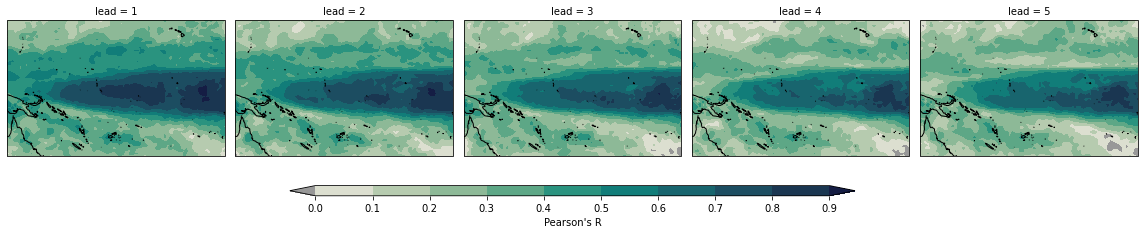

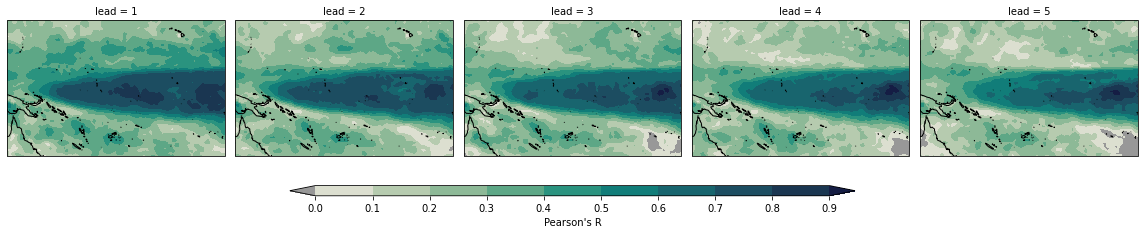

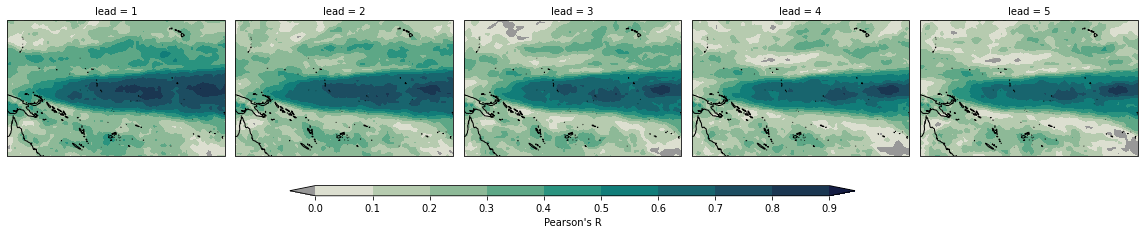

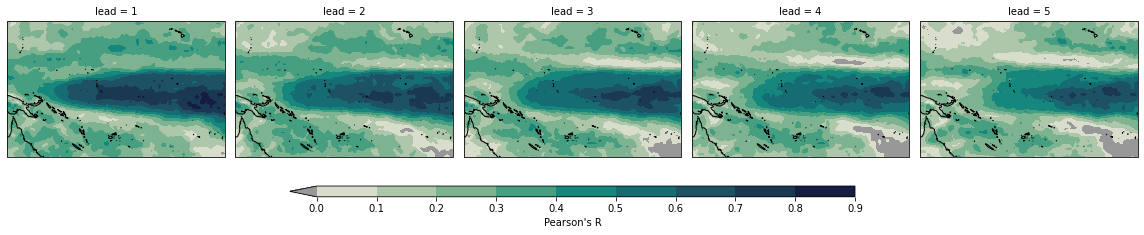

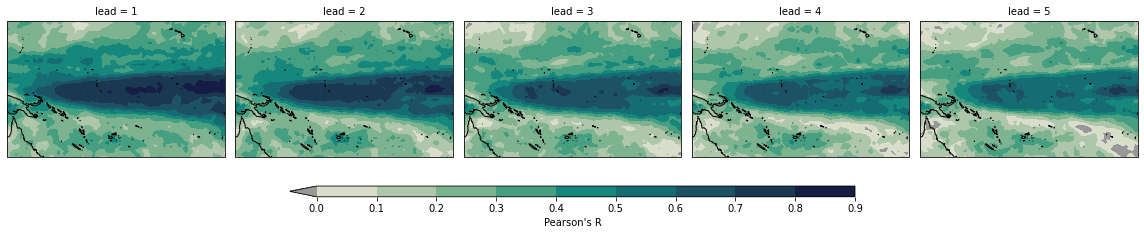

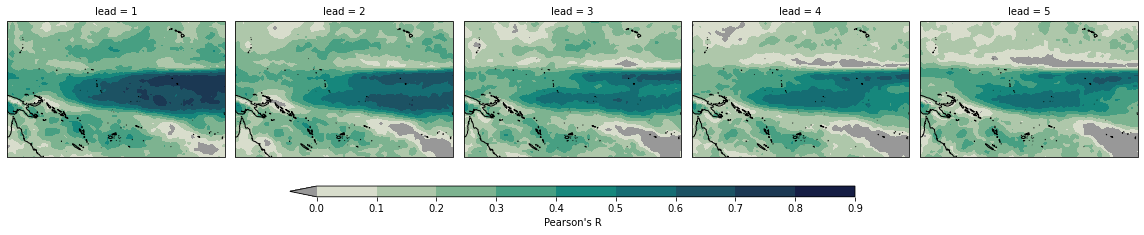

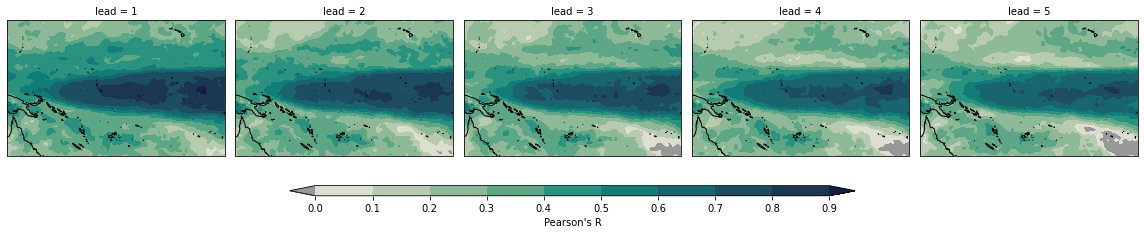

In [83]:
for GCM in R_map.GCM.data:
    
    fg = R_map.sel(GCM=GCM)['precip'].plot.contourf(col='lead', levels=np.arange(0, 1, 0.1), cmap=cmap, \
                                                  subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)}, 
                                                 transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.5, 'orientation':'horizontal', 'aspect':50, 'label':"Pearson's R"}) 


    [ax.coastlines() for ax in fg.axes.flat];

    axes = fg.axes.flat

#     [axes[i].set_title(f"R, {GCM}: {i + 1} months lead") for i in range(len(axes))]; 

    fg.fig.savefig(fig_path.joinpath(f'verification/R_map_{GCM}_all_months_{period}_{domain_name}_domain_verif_{use_verif.upper()}.png'), dpi=200, bbox_inches='tight',facecolor='w'); 

### ACC as a function of ENSO phases 

### 1) canonical ENSO 

In [84]:
nino = verification.get_CPC_NINO()

<AxesSubplot:>

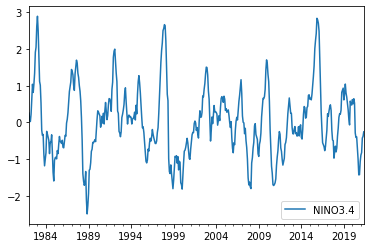

In [85]:
nino.plot()

In [86]:
nino = nino.loc['1993':'2016',:]

In [87]:
el_nino = nino.loc[nino.loc[:,'NINO3.4'] >= 0.7,:]

In [88]:
la_nina = nino.loc[nino.loc[:,'NINO3.4'] <= -0.7,:]

In [89]:
neutral = nino.loc[(nino.loc[:,'NINO3.4'] > -0.7) & (nino.loc[:,'NINO3.4'] < 0.7),:]

In [90]:
def series_to_xarray(ts): 
    ts = ts.to_xarray()
    ts = ts.rename({'index':'init'})
    return ts

In [91]:
enso = series_to_xarray(nino)

In [92]:
el_nino = series_to_xarray(el_nino)

In [93]:
la_nina = series_to_xarray(la_nina)

In [94]:
neutral = series_to_xarray(neutral)

In [95]:
ACC_nino = (hindcast.sel(init=el_nino.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-05-01 00:00:00
INFO:root:lead: 02 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-06-01 00:00:00
INFO:root:lead: 03 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-07-01 00:00:00
INFO:root:lead: 04 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-08-01 00:00:00-2016-08-01 00:00:00
INFO:root:lead: 05 | inits: 1993-04-01 00:00:00-2016-04-01 00:00:00 | verifs: 1993-09-01 00:00:00-2016-09-01 00:00:00


In [96]:
ACC_nina = (hindcast.sel(init=la_nina.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1995-09-01 00:00:00-2016-10-01 00:00:00 | verifs: 1995-10-01 00:00:00-2016-11-01 00:00:00
INFO:root:lead: 02 | inits: 1995-09-01 00:00:00-2016-10-01 00:00:00 | verifs: 1995-11-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1995-09-01 00:00:00-2012-01-01 00:00:00 | verifs: 1995-12-01 00:00:00-2012-04-01 00:00:00
INFO:root:lead: 04 | inits: 1995-09-01 00:00:00-2012-01-01 00:00:00 | verifs: 1996-01-01 00:00:00-2012-05-01 00:00:00
INFO:root:lead: 05 | inits: 1995-09-01 00:00:00-2012-01-01 00:00:00 | verifs: 1996-02-01 00:00:00-2012-06-01 00:00:00


In [97]:
ACC_neutral = (hindcast.sel(init=neutral.init)).verify(metric='acc', comparison='e2o', dim=['init','lat','lon'], alignment='maximize')

INFO:root:lead: 01 | inits: 1993-02-01 00:00:00-2016-11-01 00:00:00 | verifs: 1993-03-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 02 | inits: 1993-02-01 00:00:00-2016-10-01 00:00:00 | verifs: 1993-04-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 03 | inits: 1993-02-01 00:00:00-2016-09-01 00:00:00 | verifs: 1993-05-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 04 | inits: 1993-02-01 00:00:00-2016-08-01 00:00:00 | verifs: 1993-06-01 00:00:00-2016-12-01 00:00:00
INFO:root:lead: 05 | inits: 1993-02-01 00:00:00-2016-07-01 00:00:00 | verifs: 1993-07-01 00:00:00-2016-12-01 00:00:00


In [98]:
with ProgressBar(): 
    ACC_nino = ACC_nino.compute()
    ACC_nina = ACC_nina.compute()
    ACC_neutral = ACC_neutral.compute()

[########################################] | 100% Completed | 22.4s
[########################################] | 100% Completed | 23.4s
[########################################] | 100% Completed | 23.0s


In [99]:
ACC_nino_df = ACC_nino['precip'].to_dataframe()['precip'].unstack()
ACC_nina_df = ACC_nina['precip'].to_dataframe()['precip'].unstack()
ACC_neutral_df = ACC_neutral['precip'].to_dataframe()['precip'].unstack()

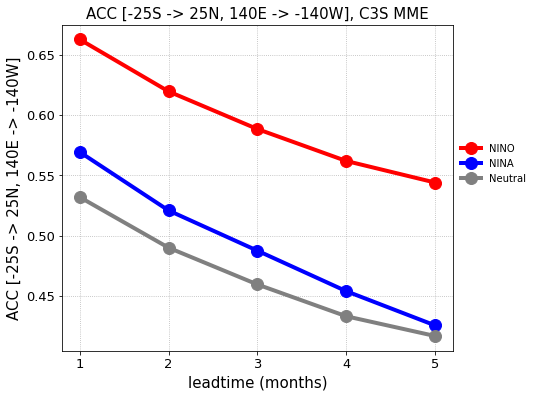

In [100]:
f, ax = plt.subplots(figsize=(7,6))

# ACC_nino_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='r', alpha=0.5, legend=False)
ACC_nino_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='r', label='NINO', lw=4)

# ACC_nina_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='b', alpha=0.5, legend=False)
ACC_nina_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='b', label='NINA', lw=4)

# ACC_neutral_df.loc[:,GCMs].plot(marker='o', markersize=10, ax=ax, color='0.5', alpha=0.5, legend=False)
ACC_neutral_df.loc[:,'MME'].plot(marker='o', markersize=12, ax=ax, color='0.5', label='Neutral', lw=4)

ax.legend()
ax.set_xlabel('leadtime (months)', fontsize=15);
ax.set_ylabel(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W]", fontsize=15);
ax.set_xticks(MME.lead.data)
ax.grid(ls=':')
# ax.set_title(f"ACC (El Nino)  [{domain[2]}S - {domain[3]}N, {domain[0]}E {domain[1] - 360}W]\nverif. = {use_verif.upper()}", fontsize=14, loc='center') 
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# # ax.set_ylim(0.15, 0.45)

plt.legend(loc=(1.01, 0.5), frameon=False); 

ax.set_title(f"ACC [{domain[2]}S -> {domain[3]}N, {domain[0]}E -> {domain[1] - 360}W], C3S MME", fontsize=15)

f.savefig(fig_path.joinpath(f'verification/ACC_{period}_C3S_{domain_name}_domain_verif_{use_verif.upper()}_ENSO.png'), dpi=200, bbox_inches='tight', facecolor='w'); 